In [ ]:
# Install 7zip
!apt-get install p7zip-full

# Extract using 7zip
!7z x /content/SalmonScan.zip -o/content/SalmonScan/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   
ERROR: No more files
/content/SalmonScan.zip



System ERROR:
Unknown error -2147024872


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp /content/SalmonScan.zip /content/drive/MyDrive/


cp: cannot stat '/content/SalmonScan.zip': No such file or directory


In [ ]:
!unzip /content/SalmonScan.zip '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented' -d /content/SalmonScan/


unzip:  cannot find or open /content/SalmonScan.zip, /content/SalmonScan.zip.zip or /content/SalmonScan.zip.ZIP.


In [ ]:
!df -h


Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   32G   82G  28% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
/dev/sda1        86G   57G   29G  67% /opt/bin/.nvidia
tmpfs           6.4G   84K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   13G  3.0G  81% /content/drive


Data Preprocessing

The input images were preprocessed to enhance their quality and suitability for further analysis. The following steps were taken:

Resizing 📏: All the images were resized to a uniform size of 600 pixels in width and 250 pixels in height to ensure compatibility with the learning algorithm.
Image Augmentation 📸: To overcome the small amount of images, various image augmentation techniques were applied to the input images. These included:
Horizontal Flip ↩️: The images were horizontally flipped to create additional samples.
Vertical Flip ⬆️: The images were vertically flipped to create additional samples.
Rotation 🔄: The images were rotated to create additional samples.
Cropping 🪓: A portion of the image was randomly cropped to create additional samples.
Gaussian Noise 🌌: Gaussian noise was added to the images to create additional samples.
Shearing 🌆: The images were sheared to create additional samples.
Contrast Adjustment (Gamma) ⚖️: The gamma correction was applied to the images to adjust their contrast.
Contrast Adjustment (Sigmoid) ⚖️: The sigmoid function was applied to the images to adjust their contrast.

In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

fresh_path = '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented/FreshFish'
infected_path = '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented/InfectedFish'

def load_and_preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [250,250])
    img = img / 255.0
    return img, label

fresh_paths = [os.path.join(fresh_path, f) for f in os.listdir(fresh_path)]
infected_paths = [os.path.join(infected_path, f) for f in os.listdir(infected_path)]

fresh_labels = [0] * len(fresh_paths)
infected_labels = [1] * len(infected_paths)

all_paths = fresh_paths + infected_paths
all_labels = fresh_labels + infected_labels

dataset = tf.data.Dataset.from_tensor_slices((all_paths, all_labels))

dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y))

dataset = dataset.shuffle(buffer_size=1000).batch(32)

train_size = int(0.8 * len(all_paths))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Image batch shape: (32, 250, 250, 3)
Label batch shape: (32,)


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.InputLayer(input_shape=(250, 250, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      13,779,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,872,449 (52.92 MB)

 Trainable params: 13,872,449 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(
    train_dataset,
    epochs=4,
    validation_data=test_dataset
)


Epoch 1/4
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5165 - loss: 2.7342
Epoch 2/4


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 244ms/step - accuracy: 0.7970 - loss: 0.4343
Epoch 3/4
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 353ms/step - accuracy: 0.8684 - loss: 0.3111
Epoch 4/4
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.8890 - loss: 0.2561


In [ ]:

test_dataset = dataset.skip(train_size)

In [ ]:

for images, labels in test_dataset.take(1):
    print(f"Test batch - Images: {images.shape}, Labels: {labels.shape}")


In [ ]:

num_batches = 0
for _ in test_dataset:
    num_batches += 1
print(f"Number of batches in test dataset: {num_batches}")


Number of batches in test dataset: 0


In [ ]:

for images, labels in test_dataset.take(1):
    test_loss, test_acc = model.evaluate(images, labels)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


In [ ]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(all_paths, all_labels, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y))
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y))

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32)
test_dataset = test_dataset.batch(32)

for images, labels in train_dataset.take(1):
    print(f"Train batch shape: {images.shape}")
    print(f"Train label batch shape: {labels.shape}")


Train batch shape: (32, 250, 250, 3)
Train label batch shape: (32,)


In [ ]:
print(f"Training paths: {len(train_paths)}")
print(f"Testing paths: {len(test_paths)}")


Training paths: 966
Testing paths: 242


In [ ]:

print(f"Total number of images: {len(all_paths)}")


Total number of images: 1208


In [ ]:

history = model.fit(
    train_dataset,
    epochs=4,
    validation_data=test_dataset
)

test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test accuracy: {test_acc}")


Epoch 1/4
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 266ms/step - accuracy: 0.9502 - loss: 0.1594 - val_accuracy: 0.9091 - val_loss: 0.2144
Epoch 2/4
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.9508 - loss: 0.1323 - val_accuracy: 0.9380 - val_loss: 0.1536
Epoch 3/4
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.9684 - loss: 0.0969 - val_accuracy: 0.9174 - val_loss: 0.2124
Epoch 4/4
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.9516 - loss: 0.1172 - val_accuracy: 0.9050 - val_loss: 0.2661
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9202 - loss: 0.2031
Test accuracy: 0.9049586653709412


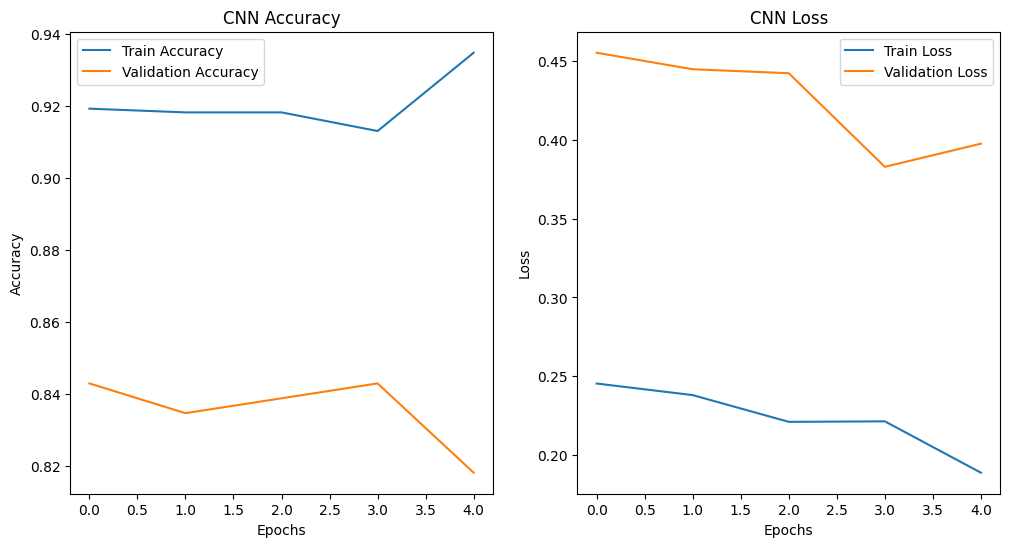

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Classification Report:

              precision    recall  f1-score   support

       Fresh       0.87      0.60      0.71       100
    Infected       0.77      0.94      0.84       142

    accuracy                           0.80       242
   macro avg       0.82      0.77      0.78       242
weighted avg       0.81      0.80      0.79       242

Confusion Matrix:

[[ 60  40]
 [  9 133]]


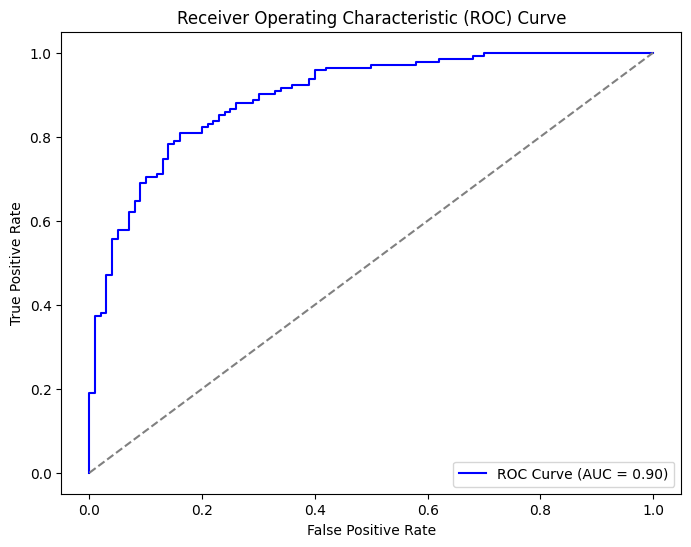

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training history for CNN
plot_training_history(history, "CNN")

# Get predictions for evaluation metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

# Convert predictions to binary (0 or 1) based on threshold
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_binary, target_names=['Fresh', 'Infected']))

# Confusion Matrix
print("Confusion Matrix:\n")
conf_matrix = confusion_matrix(y_true, y_pred_binary)
print(conf_matrix)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# **DENSE NET**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os

fresh_path = '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented/FreshFish'
infected_path = '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented/InfectedFish'

def load_and_preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [250, 600])
    img = img / 255.0
    return img, label

fresh_paths = [os.path.join(fresh_path, f) for f in os.listdir(fresh_path)]
infected_paths = [os.path.join(infected_path, f) for f in os.listdir(infected_path)]

fresh_labels = [0] * len(fresh_paths)
infected_labels = [1] * len(infected_paths)

all_paths = fresh_paths + infected_paths
all_labels = fresh_labels + infected_labels

dataset = tf.data.Dataset.from_tensor_slices((all_paths, all_labels))
dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y))

dataset = dataset.shuffle(buffer_size=1000)
train_size = int(0.8 * len(all_paths))
train_dataset = dataset.take(train_size).batch(32)
test_dataset = dataset.skip(train_size).batch(32)

def dense_block(x, growth_rate):
    bn = layers.BatchNormalization()(x)
    relu = layers.Activation('relu')(bn)
    conv = layers.Conv2D(growth_rate, (3, 3), padding='same')(relu)
    return layers.Concatenate()([x, conv])

inputs = layers.Input(shape=(250, 600, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)

x = dense_block(x, growth_rate=32)
x = layers.MaxPooling2D((2, 2))(x)

x = dense_block(x, growth_rate=32)
x = layers.MaxPooling2D((2, 2))(x)

x = dense_block(x, growth_rate=32)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

model1= models.Model(inputs, outputs)

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 250, 600, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 250, 600, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 125, 300, 32)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 125, 300, 32)   │            128 │ max_pooling2d_3[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 125, 300, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 125, 300, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 125, 300, 64)   │              0 │ max_pooling2d_3[0][0], │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 62, 150, 64)    │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 62, 150, 64)    │            256 │ max_pooling2d_4[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 62, 150, 64)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 62, 150, 32)    │         18,464 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 62, 150, 96)    │              0 │ max_pooling2d_4[0][0], │
│ (Concatenate)             │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 31, 75, 96)     │              0 │ concatenate_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 31, 75, 96)     │            384 │ max_pooling2d_5[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 31, 75, 96)     │              0 │ batch_normalization_2… │
├──────────────────────

 Total params: 73,697 (287.88 KB)

 Trainable params: 73,313 (286.38 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:

history = model1.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset
)



Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 664ms/step - accuracy: 0.7125 - loss: 0.5273 - val_accuracy: 0.4463 - val_loss: 1.0463
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - accuracy: 0.8537 - loss: 0.3460 - val_accuracy: 0.4587 - val_loss: 0.9835
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 383ms/step - accuracy: 0.8577 - loss: 0.3826 - val_accuracy: 0.8140 - val_loss: 0.4588
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 497ms/step - accuracy: 0.8973 - loss: 0.2931 - val_accuracy: 0.7727 - val_loss: 0.4950
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 481ms/step - accuracy: 0.8772 - loss: 0.3261 - val_accuracy: 0.8306 - val_loss: 0.4120


In [ ]:

test_loss, test_accuracy = model1.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8522 - loss: 0.3900
Test Accuracy: 0.8677685856819153


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.8228 - loss: 0.4113
Test Loss (DenseNet): 0.42609986662864685
Test Accuracy (DenseNet): 0.8099173307418823
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step

Classification Report (DenseNet):
              precision    recall  f1-score   support

       Fresh       0.84      0.67      0.74       100
    Infected       0.80      0.91      0.85       142

    accuracy                           0.81       242
   macro avg       0.82      0.79      0.80       242
weighted avg       0.81      0.81      0.81       242


Confusion Matrix (DenseNet):
[[ 67  33]
 [ 13 129]]


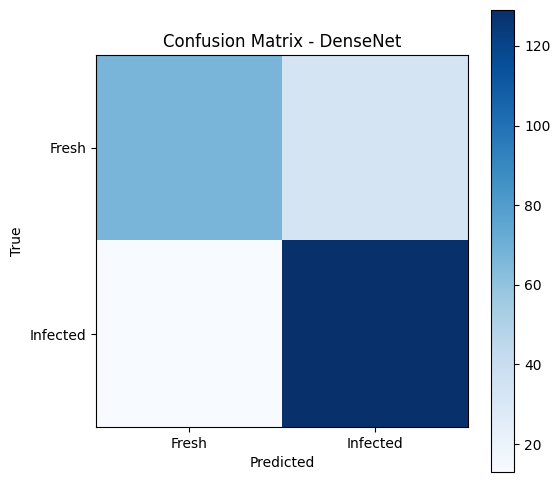

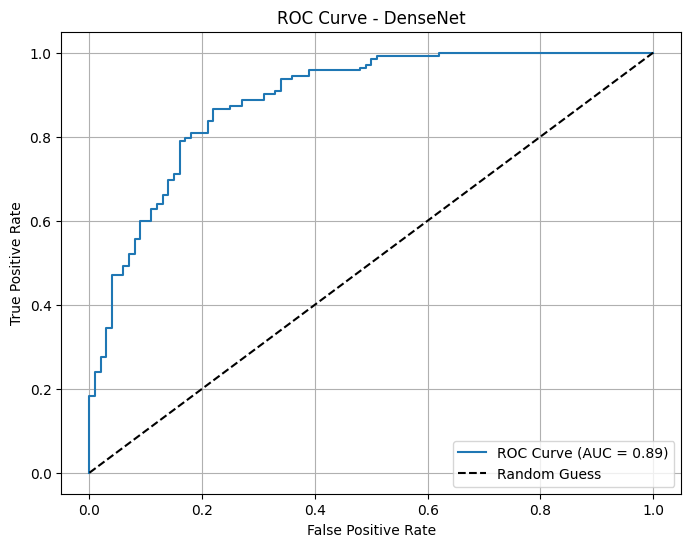

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

test_loss, test_accuracy = model1.evaluate(test_dataset)
print(f"Test Loss (DenseNet): {test_loss}")
print(f"Test Accuracy (DenseNet): {test_accuracy}")

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model1.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
print("\nClassification Report (DenseNet):")
print(classification_report(y_true, y_pred_binary, target_names=["Fresh", "Infected"]))

conf_matrix = confusion_matrix(y_true, y_pred_binary)
print("\nConfusion Matrix (DenseNet):")
print(conf_matrix)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix - DenseNet")
plt.colorbar()
plt.xticks([0, 1], ["Fresh", "Infected"])
plt.yticks([0, 1], ["Fresh", "Infected"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve - DenseNet")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


# **RESNET**

In [ ]:
from tensorflow.keras import layers, models, optimizers

def resnet_block(input_tensor, filters, kernel_size=3, stride=1):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride > 1 or input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, 1, strides=stride, padding='same')(input_tensor)

    x = layers.Add()([x, input_tensor])
    x = layers.ReLU()(x)
    return x

inputs = layers.Input(shape=(250, 600, 3))

x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = resnet_block(x, 64)
x = resnet_block(x, 128, stride=2)
x = resnet_block(x, 256, stride=2)
x = resnet_block(x, 512, stride=2)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model2= models.Model(inputs, outputs)

model2.compile(
    optimizer=optimizers.Adagrad(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 250, 600, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 125, 300, 64)   │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 125, 300, 64)   │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 125, 300, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 63, 150, 64)    │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 63, 150, 64)    │         36,928 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 63, 150, 64)    │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 63, 150, 64)    │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 63, 150, 64)    │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 63, 150, 64)    │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 63, 150, 64)    │              0 │ batch_normalization_5… │
│                           │                        │                │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 63, 150, 64)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 75, 128)    │         73,856 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 32, 75, 128)    │            512 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 75, 128)    │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 75, 128)    │        147,584 │ re_lu_3[0][0]          │
├──────────────────────

 Total params: 4,976,641 (18.98 MB)

 Trainable params: 4,972,673 (18.97 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
history = model2.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset

)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.9124 - loss: 0.2621 - val_accuracy: 0.8430 - val_loss: 0.4553
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.9204 - loss: 0.2339 - val_accuracy: 0.8347 - val_loss: 0.4448
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.9088 - loss: 0.2534 - val_accuracy: 0.8388 - val_loss: 0.4423
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - accuracy: 0.8828 - loss: 0.2851 - val_accuracy: 0.8430 - val_loss: 0.3829
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.9400 - loss: 0.1813 - val_accuracy: 0.8182 - val_loss: 0.3976


In [ ]:

test_loss, test_accuracy = model2.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.8080 - loss: 0.3855
Test Accuracy: 0.8181818127632141


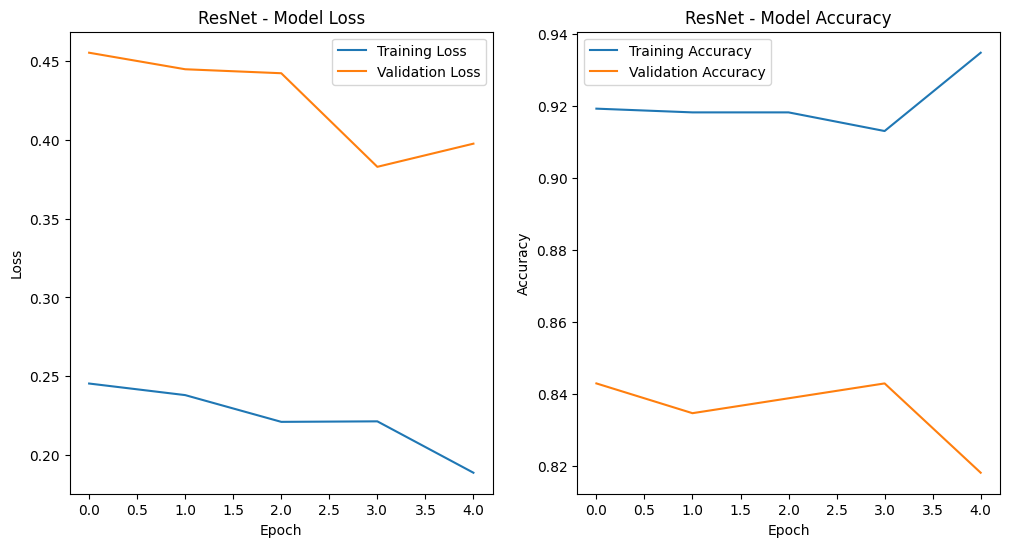

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


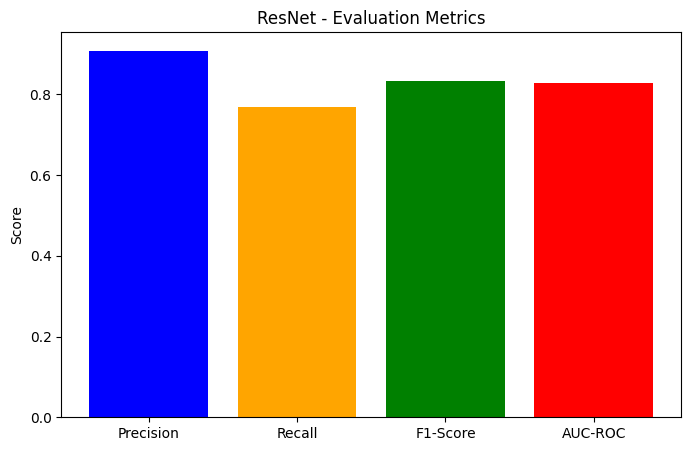

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history, "ResNet")
def plot_metrics(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC-ROC': roc_auc}

    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red'])
    plt.title(f'{model_name} - Evaluation Metrics')
    plt.ylabel('Score')
    plt.show()

y_true = []
y_pred = []
for images, labels in test_dataset:
    predictions = model2.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
plot_metrics(y_true, y_pred_binary, "ResNet")

In [ ]:
import tensorflow as tf
import os

fresh_path = '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented/FreshFish'
infected_path = '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented/InfectedFish'

fresh_paths = [os.path.join(fresh_path, f) for f in os.listdir(fresh_path)]
infected_paths = [os.path.join(infected_path, f) for f in os.listdir(infected_path)]
num_fresh = len(fresh_paths)
num_infected = len(infected_paths)

num_augmentations_needed = num_infected - num_fresh
print(f"Augmenting {num_augmentations_needed} 'fresh' images.")
image_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
])

augmented_fresh_images = []
for img_path in fresh_paths:
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [250, 600])
    img = img / 255.0

    for _ in range(num_augmentations_needed // num_fresh):
        augmented_img = image_augmentation(img)
        augmented_fresh_images.append(augmented_img)
new_fresh_images = fresh_paths + augmented_fresh_images

print(f"New total number of fresh images: {len(new_fresh_images)}")


Augmenting 296 'fresh' images.
New total number of fresh images: 456


In [ ]:
print(f"New total number of fresh images: {len(new_fresh_images)}")

New total number of fresh images: 456


In [ ]:
num_fresh = len(fresh_paths)
print(f"Total number of fresh images: {num_fresh}")
num_infected = len(infected_paths)
print(f"Total number of infected images: {num_infected}")


Total number of fresh images: 456
Total number of infected images: 752


In [ ]:
fresh = '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented/FreshFish'
infected= '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented/InfectedFish'

fresh_image_count = len(os.listdir(fresh))
infected_image_count = len(os.listdir(infected))

print(f"Number of Fresh Fish images: {fresh_image_count}")
print(f"Number of Infected Fish images: {infected_image_count}")

Number of Fresh Fish images: 456
Number of Infected Fish images: 752


#LeNet

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

# Paths to dataset
fresh_path = '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented/FreshFish'
infected_path = '/content/drive/MyDrive/SalmonScan/SalmonScan/Augmented/InfectedFish'
def load_and_preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, [250, 600])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label
fresh_paths = [os.path.join(fresh_path, f) for f in os.listdir(fresh_path) if f.endswith('.png')]
infected_paths = [os.path.join(infected_path, f) for f in os.listdir(infected_path) if f.endswith('.png')]
fresh_labels = [0] * len(fresh_paths)
infected_labels = [1] * len(infected_paths)
all_paths = fresh_paths + infected_paths
all_labels = fresh_labels + infected_labels

train_paths, test_paths, train_labels, test_labels = train_test_split(all_paths, all_labels, test_size=0.2, random_state=42)
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
train_dataset = train_dataset.map(load_and_preprocess_image).shuffle(buffer_size=1000).batch(32)
test_dataset = test_dataset.map(load_and_preprocess_image).batch(32)

In [ ]:
model = models.Sequential([
    layers.InputLayer(input_shape=(250, 600, 3)),
    layers.Conv2D(6, (5, 5), activation='relu', padding='same'),
    layers.AvgPool2D((2, 2), strides=2, padding='valid'),
    layers.Conv2D(16, (5, 5), activation='relu', padding='valid'),
    layers.AvgPool2D((2, 2), strides=2, padding='valid'),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 250, 600, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 125, 300, 6)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 121, 296, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 60, 148, 16)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 142080)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 120)                 │      17,049,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,062,841 (65.09 MB)

 Trainable params: 17,062,841 (65.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(
    train_dataset,
    epochs=4,
    validation_data=test_dataset
)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

Epoch 1/4
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - accuracy: 0.5871 - loss: 1.4135 - val_accuracy: 0.8636 - val_loss: 0.4098
Epoch 2/4
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.8470 - loss: 0.3962 - val_accuracy: 0.8884 - val_loss: 0.3018
Epoch 3/4
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9240 - loss: 0.2119 - val_accuracy: 0.7851 - val_loss: 0.5393
Epoch 4/4
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.9482 - loss: 0.1439 - val_accuracy: 0.8636 - val_loss: 0.2998
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8553 - loss: 0.2878
Test accuracy: 0.8636363744735718


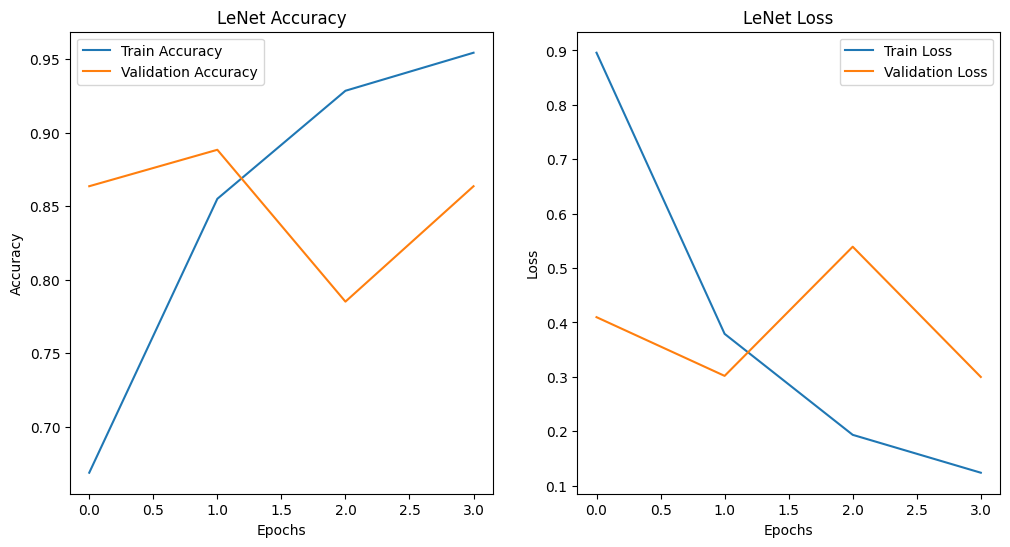

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Classification Report:

              precision    recall  f1-score   support

       Fresh       0.78      0.93      0.85       100
    Infected       0.94      0.82      0.88       142

    accuracy                           0.86       242
   macro avg       0.86      0.87      0.86       242
weighted avg       0.88      0.86      0.86       242

Confusion Matrix:

[[ 93   7]
 [ 26 116]]


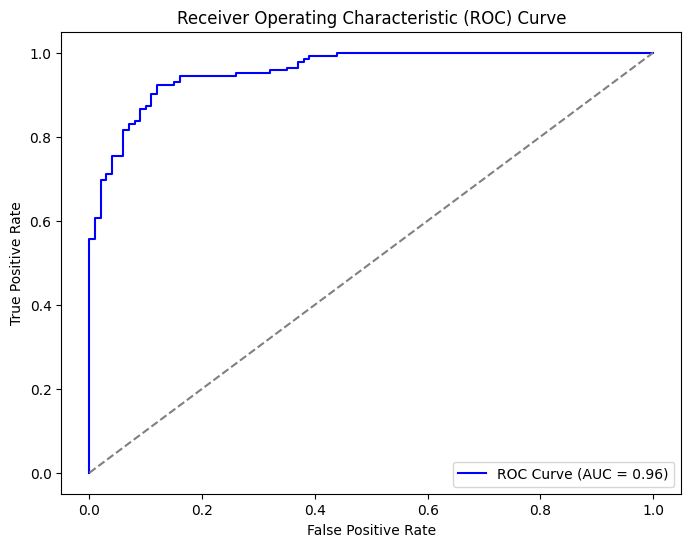

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history, "LeNet")
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
print("Classification Report:\n")
print(classification_report(y_true, y_pred_binary, target_names=['Fresh', 'Infected']))

print("Confusion Matrix:\n")
conf_matrix = confusion_matrix(y_true, y_pred_binary)
print(conf_matrix)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()